# Classification with PyTorch/TensorFlow

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

## Part 1: Iris Classification

Iris Dataset contains 150 records of 3 different classes of irises. Each record contains 4 numeric parameters: sepal length/width and petal length/width. It is an example of a simple dataset, for which you do not need a powerful neural network.

### Getting the Dataset

Iris dataset is build into Scikit Learn, so we can easily get it:

In [79]:
from sklearn.datasets import load_iris
#from sklearn.model_selection import train_test_split

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


### Visualize the Data

In many cases, it makes sense to visualize the data to see if they look separable - it would assure us that we should be able to build good classification model. Because we have a few features, we can build a series of pairwise 2D scatter plots, showing different classes by different dot colors. This can be automatically done by a package called **seaborn**:

In [80]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


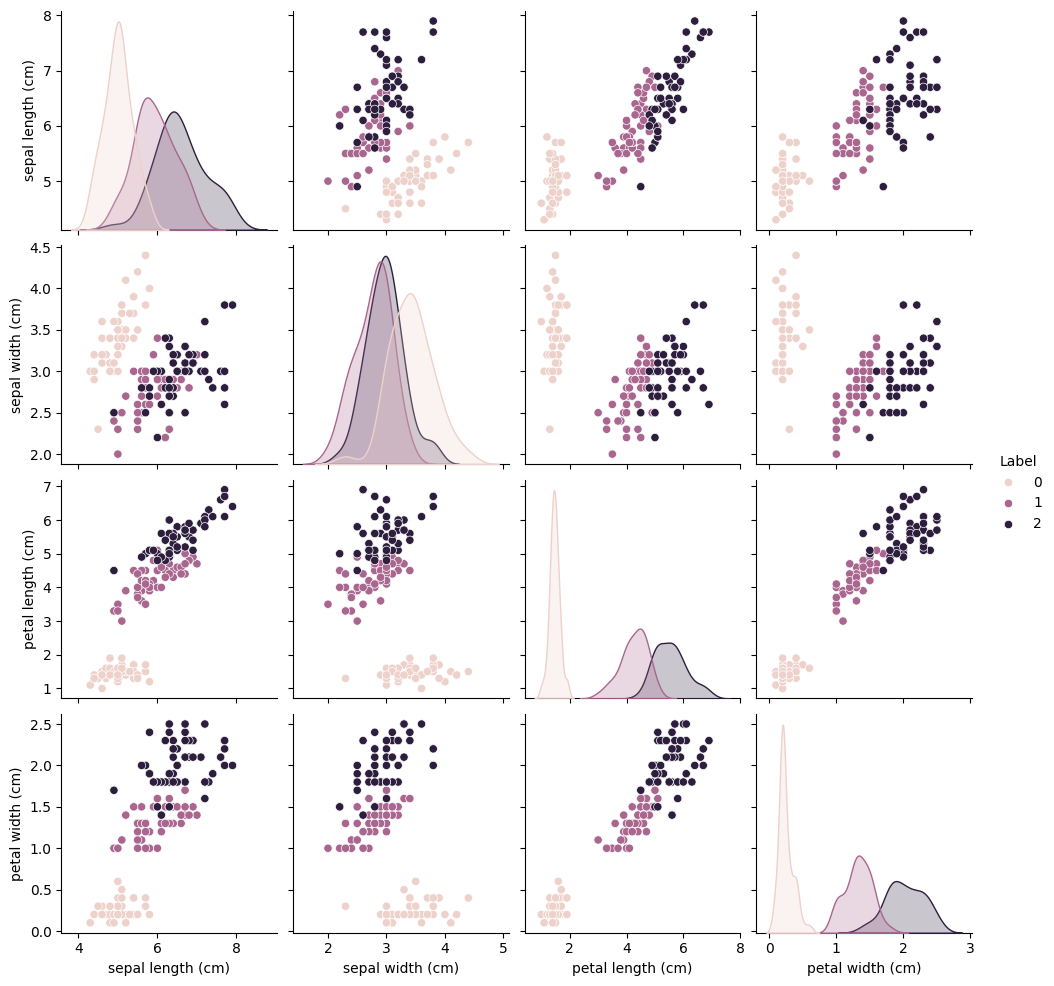

In [81]:
sns.pairplot(df,hue='Label')

### Normalize and Encode the Data

To prepare data to neural network training, we need to normalize inputs in the range [0,1]. We do this using plain `numpy` operations.

Since PyTorch allows you to feed in class number  as an integer (from 0 to N-1) we do not transform the labels. After transforming the normalized features and labels into PyTorch tensors we load it into a Dataset class.
``` 

In [82]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

features_max = features.max(axis=0, keepdims=True)
features_min = features.min(axis=0, keepdims=True)
normalized_features = (features-features_min)/(features_max-features_min)

features_tensor = torch.Tensor(normalized_features)
labels_tensor = torch.Tensor(labels).type(torch.LongTensor)
dataset = data_utils.TensorDataset(features_tensor, labels_tensor)


### Split the Data into Train and Test

We still need to split the dataset in train data and test data. We use the `random_split` function in PyTorch for this.

In [83]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = data_utils.random_split(dataset,[train_size, test_size])

batch_size = 10
train_loader = data_utils.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = data_utils.DataLoader(test_data, batch_size=10, shuffle=True)

In [84]:
for features, labels in train_loader:
    print(features.shape)

torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])


### Define and Train Neural Network

The assignment suggested that we use a neural network with one, two or three layers. These are implemented below. We chose to use relatively large hidden layers, as these seem to give good results.

In [85]:
class OneLayerNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,3)

    def forward(self, x):
        x=self.linear1(x)
        return x
    
class TwoLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,50)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(50,3)

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x
    
class ThreeLayernet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,50)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(50,50)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(50,3)

    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        x = self.linear3(x)
        return x

The following two funtions implement the training loop. One function trains the model for one epoch and the other function implements the whole training cycle.

In [86]:
def train_epoch(model, loss_fn, dataloader, optimizer, report_freq):
    epoch_loss=[]
    running_loss = 0.0
    for j, data in enumerate(dataloader):
            features, labels = data

            optimizer.zero_grad()

            preds = model(features)
            batch_loss = loss_fn(preds, labels)
            batch_loss.backward()
            optimizer.step()

            epoch_loss.append(batch_loss.item())
            running_loss+=batch_loss.item()
            if j%report_freq==report_freq-1:
                print(f"batch {j+1}, loss: {running_loss/report_freq}")
                running_loss = 0.0
    return epoch_loss

def train_model(model, loss_fn,train_loader, test_loader, optimizer,no_of_epochs, report_freq):
    train_loss = []
    val_loss = []
    accuracy = []
    epoch_number = 1
    for epoch in range(no_of_epochs):
        #epoch_loss = []
        print(f"EPOCH {epoch_number}:")
        model.train(True)
        epoch_loss = train_epoch(model,loss_fn, train_loader, optimizer, report_freq)
        train_loss+=epoch_loss
            
        running_vloss = 0.0
        model.eval()
        with torch.no_grad():
             for i, vdata in enumerate(test_loader):
                  vfeatures, vlabels = vdata
                  vpred = model(vfeatures)
                  vloss = loss_fn(vpred,vlabels)
                  correct = (torch.argmax(vpred, dim=1) == vlabels).type(torch.FloatTensor)
                  val_loss.append(vloss.item())
                  running_vloss+=vloss.item()
                  accuracy.append(correct.mean().item())
        

        val_loss.append(running_vloss/(i+1))
        train_loss+=epoch_loss
        print(f"LOSS train {epoch_loss[-1]}, val: {val_loss[-1]}")

        epoch_number+=1
    return train_loss, val_loss, accuracy
    

Now we are ready to train the models. We will train for 50 epochs.

In [87]:
no_of_epochs = 50
net1 = OneLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim1 = torch.optim.SGD(net1.parameters(), lr=0.01, momentum=0.9)

train_loss1, val_loss1, acc1 = train_model(net1,loss_fn,train_loader,test_loader,optim1, no_of_epochs, report_freq=5)


EPOCH 1:
batch 5, loss: 1.2334187984466554
batch 10, loss: 1.1728420019149781
LOSS train 0.8932879567146301, val: 1.126407225926717
EPOCH 2:
batch 5, loss: 1.1108540296554565
batch 10, loss: 1.0886957883834838
LOSS train 1.1345802545547485, val: 1.0487457911173503
EPOCH 3:
batch 5, loss: 1.0372134447097778
batch 10, loss: 1.011146318912506
LOSS train 0.9528806805610657, val: 0.9901617964108785
EPOCH 4:
batch 5, loss: 0.9604948282241821
batch 10, loss: 0.9415705919265747
LOSS train 1.0055859088897705, val: 0.9407486120859782
EPOCH 5:
batch 5, loss: 0.902565860748291
batch 10, loss: 0.9389204740524292
LOSS train 0.8502960205078125, val: 0.9001003901163737
EPOCH 6:
batch 5, loss: 0.8658889770507813
batch 10, loss: 0.8869335412979126
LOSS train 0.8526056408882141, val: 0.8656063675880432
EPOCH 7:
batch 5, loss: 0.8262851476669312
batch 10, loss: 0.8432920336723327
LOSS train 0.8248605728149414, val: 0.8320482969284058
EPOCH 8:
batch 5, loss: 0.8102646827697754
batch 10, loss: 0.80152560472

LOSS train 0.6554225087165833, val: 0.6837967832883199
EPOCH 15:
batch 5, loss: 0.6440534353256225
batch 10, loss: 0.6603627920150756
LOSS train 0.6026991605758667, val: 0.6658565600713094
EPOCH 16:
batch 5, loss: 0.6255717992782592
batch 10, loss: 0.6305760860443115
LOSS train 0.7035006880760193, val: 0.652467687924703
EPOCH 17:
batch 5, loss: 0.6516604661941529
batch 10, loss: 0.5980058193206788
LOSS train 0.6119219064712524, val: 0.6394562721252441
EPOCH 18:
batch 5, loss: 0.5851751863956451
batch 10, loss: 0.652049434185028
LOSS train 0.6117865443229675, val: 0.6280552347501119
EPOCH 19:
batch 5, loss: 0.6283770561218261
batch 10, loss: 0.5649656772613525
LOSS train 0.6331436634063721, val: 0.6180296937624613
EPOCH 20:
batch 5, loss: 0.5421634078025818
batch 10, loss: 0.6280484080314637
LOSS train 0.6615574955940247, val: 0.6080987652142843
EPOCH 21:
batch 5, loss: 0.5891653776168824
batch 10, loss: 0.5438687801361084
LOSS train 0.5862610936164856, val: 0.5992715756098429
EPOCH 22:

In [88]:
no_of_epochs = 50
net2 = TwoLayerNet()
optim2 = torch.optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

train_loss2, val_loss2, acc2 = train_model(net2,loss_fn,train_loader,test_loader,optim2, no_of_epochs, report_freq=5)

EPOCH 1:
batch 5, loss: 1.0951657056808473
batch 10, loss: 1.0665106296539306
LOSS train 1.1254832744598389, val: 1.014126181602478
EPOCH 2:
batch 5, loss: 0.9840526342391968
batch 10, loss: 0.9745043396949769
LOSS train 0.9059383273124695, val: 0.91236412525177
EPOCH 3:
batch 5, loss: 0.8961216926574707
batch 10, loss: 0.8503464221954345
LOSS train 0.7744344472885132, val: 0.809025247891744
EPOCH 4:
batch 5, loss: 0.7585492968559265
batch 10, loss: 0.7362537980079651
LOSS train 0.7387093305587769, val: 0.6999151309331259
EPOCH 5:
batch 5, loss: 0.6943388700485229
batch 10, loss: 0.6520664095878601
LOSS train 0.5879970788955688, val: 0.6200546224912008
EPOCH 6:
batch 5, loss: 0.564145278930664
batch 10, loss: 0.6106085896492004
LOSS train 0.5454670190811157, val: 0.5568980673948923
EPOCH 7:
batch 5, loss: 0.5409701824188232
batch 10, loss: 0.5289545774459838
LOSS train 0.42560848593711853, val: 0.5151303013165792
EPOCH 8:
batch 5, loss: 0.48147528171539306
batch 10, loss: 0.46510369181

In [89]:
no_of_epochs = 50
net3 = ThreeLayernet()
#loss_fn = torch.nn.CrossEntropyLoss()
optim3 = torch.optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)

train_loss3, val_loss3, acc3 = train_model(net3,loss_fn,train_loader,test_loader,optim3, no_of_epochs, report_freq=5)

EPOCH 1:
batch 5, loss: 1.090304923057556
batch 10, loss: 1.068053126335144
LOSS train 1.0557610988616943, val: 1.0593314170837402
EPOCH 2:
batch 5, loss: 1.0479215383529663
batch 10, loss: 1.0375729560852052
LOSS train 0.9932006597518921, val: 1.008482317129771
EPOCH 3:
batch 5, loss: 0.9806522846221923
batch 10, loss: 0.9607220411300659
LOSS train 0.9812663793563843, val: 0.9308102329572042
EPOCH 4:
batch 5, loss: 0.9112351298332214
batch 10, loss: 0.8568620800971984
LOSS train 0.7531620264053345, val: 0.8051547209421793
EPOCH 5:
batch 5, loss: 0.763913631439209
batch 10, loss: 0.7039438486099243
LOSS train 0.5937376618385315, val: 0.6605731248855591
EPOCH 6:
batch 5, loss: 0.6678676605224609
batch 10, loss: 0.5505656123161315
LOSS train 0.41752153635025024, val: 0.5458399653434753
EPOCH 7:
batch 5, loss: 0.4756708800792694
batch 10, loss: 0.5274213969707489
LOSS train 0.3060411214828491, val: 0.47307546933492023
EPOCH 8:
batch 5, loss: 0.4159665584564209
batch 10, loss: 0.4812591254

### Plot of results

Below we plot the training and validation loss as well as the accuracy of the classification. All models show good convergence with increasing performance as the number of layers increases.

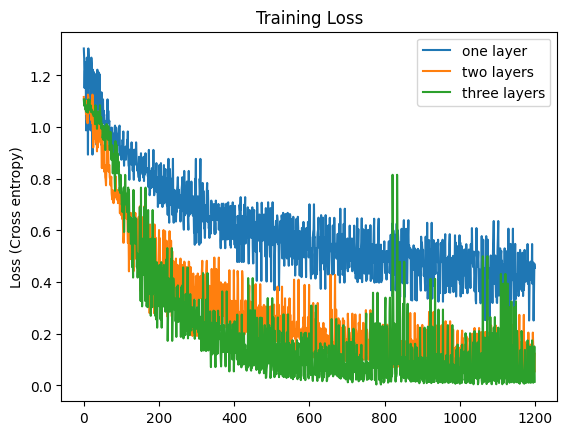

In [90]:
from matplotlib import pyplot as plt
plt.plot(train_loss1, label='one layer')
plt.plot(train_loss2, label='two layers')
plt.plot(train_loss3, label='three layers')
plt.ylabel("Loss (Cross entropy)")
plt.title("Training Loss")
plt.legend()


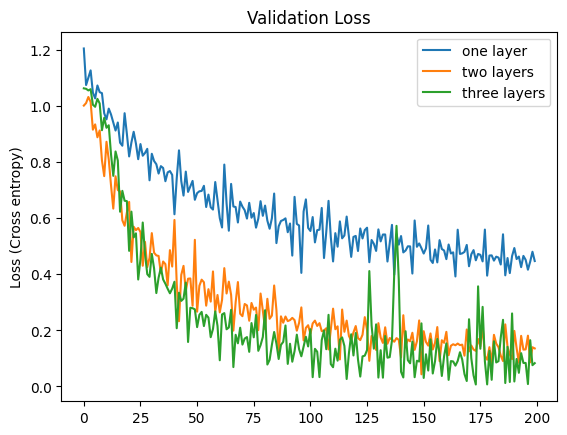

In [91]:
plt.plot(val_loss1, label='one layer')
plt.plot(val_loss2, label='two layers')
plt.plot(val_loss3, label='three layers')
plt.ylabel("Loss (Cross entropy)")
plt.title("Validation Loss")
plt.legend()

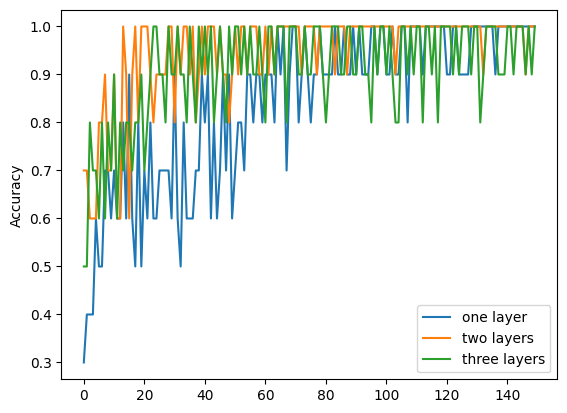

In [92]:
from matplotlib import pyplot as plt
plt.plot(acc1, label='one layer')
plt.plot(acc2, label='two layers')
plt.plot(acc3, label='three layers')
plt.ylabel("Accuracy")
#plt.title("Training Loss")
plt.legend()

## Part 2: MNIST Training

Both Keras and PyTorch contain MNIST as built-in dataset, so you can easily get it with a couple of lines of code ([Keras](https://keras.io/api/datasets/mnist/), [PyTorch](https://pytorch.org/vision/stable/datasets.html)). You will also be able to load both train and test datasets without manually splitting them.

In [93]:
import torchvision
import torchvision.transforms as tf

transform = tf.ToTensor()

mnist_dataset_train = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
mnist_dataset_test = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)

batch_size=100
mnist_train_loader = data_utils.DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = data_utils.DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [94]:
class MNISTOneLayerNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784,10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.linear1(x)
    
class MNISTTwoLayerNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784,1024)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(1024,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation1(self.linear1(x))
        return self.linear2(x)
    
class MNISTThreeLayerNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784,1024)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(1024,1024)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(1024,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        return self.linear3(x)
    

In [95]:
no_of_epochs = 5
net1 = MNISTOneLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim1 = torch.optim.SGD(net1.parameters(), lr=0.01, momentum=0.9)

train_loss1, val_loss1, acc1 = train_model(net1,loss_fn, mnist_train_loader, mnist_test_loader, optim1, no_of_epochs,report_freq=100)

EPOCH 1:
batch 500, loss: 0.5764126068651676
LOSS train 0.38248714804649353, val: 0.3626412037014961
EPOCH 2:
batch 500, loss: 0.360755535364151
LOSS train 0.3032442033290863, val: 0.32544242963194847
EPOCH 3:
batch 500, loss: 0.33379822555184363
LOSS train 0.2584894001483917, val: 0.30688293859362603
EPOCH 4:
batch 500, loss: 0.3126507574021816
LOSS train 0.19748367369174957, val: 0.30040007025003435
EPOCH 5:
batch 500, loss: 0.3074851495325565
LOSS train 0.30090487003326416, val: 0.2924052906036377


In [96]:
no_of_epochs = 5
net2 = MNISTTwoLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim2 = torch.optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

train_loss2, val_loss2, acc2 = train_model(net2,loss_fn, mnist_train_loader, mnist_test_loader, optim2, no_of_epochs,report_freq=100)

EPOCH 1:
batch 100, loss: 1.2479509165883065
batch 200, loss: 0.46113020688295364
batch 300, loss: 0.3783235102891922
batch 400, loss: 0.3491646385192871
batch 500, loss: 0.3297490592300892
batch 600, loss: 0.3012294703722
LOSS train 0.41318604350090027, val: 0.27820149905979635
EPOCH 2:
batch 100, loss: 0.28970421954989434
batch 200, loss: 0.26555127806961537
batch 300, loss: 0.2596933977305889
batch 400, loss: 0.251506190225482
batch 500, loss: 0.23208934485912322
batch 600, loss: 0.23139531515538692
LOSS train 0.3937847912311554, val: 0.21536283515393734
EPOCH 3:
batch 100, loss: 0.2067590406537056
batch 200, loss: 0.20192446455359458
batch 300, loss: 0.19986844651401042
batch 400, loss: 0.1998817089945078
batch 500, loss: 0.19752722389996052
batch 600, loss: 0.18343594945967198
LOSS train 0.271793395280838, val: 0.17599207881838083
EPOCH 4:
batch 100, loss: 0.17238687116652726
batch 200, loss: 0.1745307270437479
batch 300, loss: 0.164855938591063
batch 400, loss: 0.1509541968628764

In [97]:
no_of_epochs = 5
net3 = MNISTThreeLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim3 = torch.optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)

train_loss3, val_loss3, acc3 = train_model(net3,loss_fn, mnist_train_loader, mnist_test_loader, optim3, no_of_epochs,report_freq=100)

EPOCH 1:
batch 100, loss: 1.6755037420988084
batch 200, loss: 0.4992652517557144
batch 300, loss: 0.36960633933544157
batch 400, loss: 0.35184087738394737
batch 500, loss: 0.3061105824261904
batch 600, loss: 0.284243336468935
LOSS train 0.29878875613212585, val: 0.250065955594182
EPOCH 2:
batch 100, loss: 0.2513137712329626
batch 200, loss: 0.2373563478142023
batch 300, loss: 0.22154234983026982
batch 400, loss: 0.2030672489851713
batch 500, loss: 0.21133800245821477
batch 600, loss: 0.1930986375361681
LOSS train 0.20515693724155426, val: 0.17273943781852721
EPOCH 3:
batch 100, loss: 0.17187741078436375
batch 200, loss: 0.16931383080780507
batch 300, loss: 0.1640376327186823
batch 400, loss: 0.1496745254099369
batch 500, loss: 0.14354597494006158
batch 600, loss: 0.1302702210098505
LOSS train 0.12502899765968323, val: 0.13338304992765188
EPOCH 4:
batch 100, loss: 0.12221344839781523
batch 200, loss: 0.1302922886237502
batch 300, loss: 0.12270516857504844
batch 400, loss: 0.111035648658

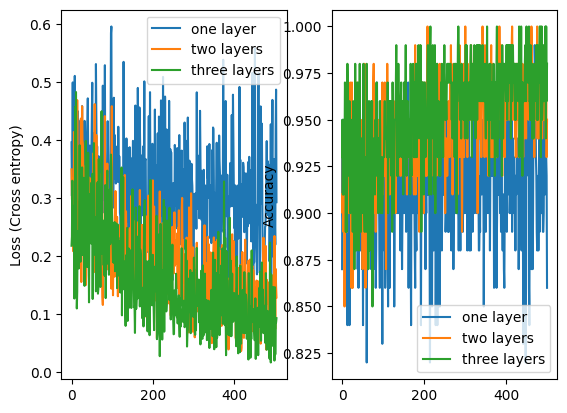

In [98]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(val_loss1, label='one layer')
ax1.plot(val_loss2, label='two layers')
ax1.plot(val_loss3, label='three layers')
ax1.set_ylabel("Loss (Cross entropy)")
#ax1.title("Validation Loss")
ax1.legend()

ax2.plot(acc1, label='one layer')
ax2.plot(acc2, label='two layers')
ax2.plot(acc3, label='three layers')
ax2.set_ylabel("Accuracy")
#plt.title("Training Loss")
ax2.legend()
plt.show()


Now you need to perform the steps above to make sure dataset is normalized (it would probably already be), defining and training a neural network.

## Takeaway

1. Neural networks can be used for traditional machine learning tasks. However, they are in many cases too powerful, and can cause overfitting.
1. It is important in this assignment that you observe the overfitting behavior, and try to avoid it.
1. With frameworks like Keras, sometimes training a neural network is quite straightforward. But you need to understand what goes on.